In [58]:
import numpy as np

import os
import fnmatch
from natsort import natsorted, ns

from matplotlib import image
from matplotlib import pyplot

In [16]:
datasets_path = os.path.join(os.getcwd(), "../Local/datasets/data/")
shapenet_path = os.path.join(datasets_path, "ShapeNet/")
NMR_path = os.path.join(datasets_path, "NMR_Dataset/")

In [17]:
class_id = "02958343"

In [18]:
working_path = os.path.join(NMR_path, class_id)

In [24]:
def list_instance_ids(class_path):
    for f in os.listdir(class_path):
        if os.path.isdir(os.path.join(class_path, f)):
            yield f
def list_image_in_dir(path, ext="png"):
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and not f.startswith('.') and fnmatch.fnmatch(f, '*.{}'.format(ext)):
            yield f

In [20]:
instance_ids = [f for f in list_instance_ids(working_path)]
print("found {} instances".format(len(instance_ids)))

found 7496 instances


In [25]:
print(os.listdir(os.path.join(working_path, instance_ids[0])))
print(os.listdir(os.path.join(working_path, instance_ids[0], "image")))
images = [f for f in list_image_in_dir(os.path.join(working_path, instance_ids[0], "image"))]
print("found {} images".format(len(images)))

['cameras.npz', 'pointcloud.npz', 'image', 'mask', 'visual_hull_depth']
['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png']
found 24 images


In [30]:
def show_images(class_path, instance_id):
    instance_path = os.path.join(class_path, instance_id, "image")
    image_names = [f for f in list_image_in_dir(instance_path)]
    image_paths = [os.path.join(os.path.join(instance_path, f)) for f in image_names]
    n_rows = int(np.sqrt(len(image_names)) + 1)

    for i in range(0, len(image_names)):
        img = image.imread(image_paths[i])
        pyplot.subplot(n_rows, n_rows, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(img)

    pyplot.show()

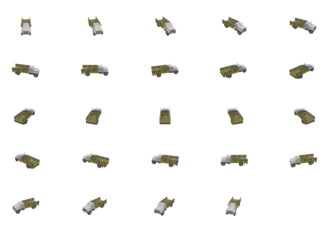

In [36]:
show_images(working_path, instance_ids[23])

In [51]:
def camera_path(class_path, instance_id):
    return os.path.join(class_path, instance_id, 'cameras.npz')

In [59]:
with np.load(file=camera_path(working_path, instance_ids[23]), mmap_mode=None, allow_pickle=False, fix_imports=True) as f:
    print(natsorted(list(f.keys()), alg=ns.IGNORECASE))

['camera_mat_0', 'camera_mat_1', 'camera_mat_2', 'camera_mat_3', 'camera_mat_4', 'camera_mat_5', 'camera_mat_6', 'camera_mat_7', 'camera_mat_8', 'camera_mat_9', 'camera_mat_10', 'camera_mat_11', 'camera_mat_12', 'camera_mat_13', 'camera_mat_14', 'camera_mat_15', 'camera_mat_16', 'camera_mat_17', 'camera_mat_18', 'camera_mat_19', 'camera_mat_20', 'camera_mat_21', 'camera_mat_22', 'camera_mat_23', 'camera_mat_inv_0', 'camera_mat_inv_1', 'camera_mat_inv_2', 'camera_mat_inv_3', 'camera_mat_inv_4', 'camera_mat_inv_5', 'camera_mat_inv_6', 'camera_mat_inv_7', 'camera_mat_inv_8', 'camera_mat_inv_9', 'camera_mat_inv_10', 'camera_mat_inv_11', 'camera_mat_inv_12', 'camera_mat_inv_13', 'camera_mat_inv_14', 'camera_mat_inv_15', 'camera_mat_inv_16', 'camera_mat_inv_17', 'camera_mat_inv_18', 'camera_mat_inv_19', 'camera_mat_inv_20', 'camera_mat_inv_21', 'camera_mat_inv_22', 'camera_mat_inv_23', 'world_mat_0', 'world_mat_1', 'world_mat_2', 'world_mat_3', 'world_mat_4', 'world_mat_5', 'world_mat_6', 'w

In [69]:
def load_camera_matrices(class_path, instance_id, id):
    file_path = camera_path(class_path, instance_id)
    with np.load(file_path) as camera_dict:
        Rt = camera_dict['world_mat_%d' % id].astype(np.float32)
        K = camera_dict['camera_mat_%d' % id].astype(np.float32)
    return Rt, K

In [70]:
load_camera_matrices(working_path, instance_ids[23], 0)

(array([[ 0.        ,  0.        , -1.        ,  0.        ],
        [ 0.5       , -0.8660254 ,  0.        ,  0.        ],
        [-0.8660254 , -0.49999997,  0.        ,  2.7319999 ]],
       dtype=float32),
 array([[3.732051, 0.      , 0.      , 0.      ],
        [0.      , 3.732051, 0.      , 0.      ],
        [0.      , 0.      , 1.      , 0.      ],
        [0.      , 0.      , 0.      , 1.      ]], dtype=float32))

In [74]:
def is_rotation_matrix(R):
    R_t = np.transpose(R)
    R_t_R = np.dot(R_t, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - R_t_R)
    return n < 1e-6

In [76]:
is_rotation_matrix(load_camera_matrices(working_path, instance_ids[23], 0)[0][0:3, 0:3])

True